# Code to compare one-minute, one-second and Gillespie simulation


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, describe, spearmanr
import scipy.stats as stats
import statsmodels.api as sm
import pylab as py

## First, calculate theoretical mean protein levels


In [2]:
def calculate_protein_level_with_regulation(params, hill_response=0.0, r_add=10, 
                                          splicing_half_life=7/60):
    """
    Calculate steady-state protein level given gene parameters and regulatory input.
    
    Args:
        params (array-like): Gene parameters in order:
            [k_on, k_off, burst_size, mrna_half_life, protein_half_life, protein_production_rate]
        hill_response (float): Desired Hill function output (0-1)
            0 = no regulation, 1 = maximum activation
        r_add (float): Maximum regulatory effect strength (default 10)
        splicing_half_life (float): mRNA maturation time (hours, default 7 min)
    
    Returns:
        float: Steady-state protein level
    """
    
    # Unpack parameters in order
    p_on,p_off,mrna_half_life,protein_half_life,p_prod_protein,p_prod_mRNA = params
    
    # Convert half-lives to degradation rates
    mrna_deg_rate = np.log(2) / mrna_half_life
    protein_deg_rate = np.log(2) / protein_half_life
    splicing_rate = np.log(2) / splicing_half_life
    
    # Calculate transcription rate from burst parameters
    transcription_rate = p_prod_mRNA
    
    
    # Apply regulation: k_on_eff = k_on + r_add * hill_response
    k_on_eff = p_on + r_add * hill_response
    k_on_eff = max(k_on_eff, 1e-10)  # Ensure positive
    
    # Calculate steady-state levels through the cascade
    # 1. Bursting probability
    burst_prob = k_on_eff / (k_on_eff + p_off)
    
    # 2. Unspliced mRNA level
    unspliced_mrna = transcription_rate * burst_prob / (mrna_deg_rate)
    
    # 4. Protein level
    protein_level = unspliced_mrna * p_prod_protein / protein_deg_rate
    # print(unspliced_mrna + spliced_mrna)
    return protein_level

In [12]:
# params_gene_1 = [0.27,8.4,23.81,25,100,2000]
# params_gene_2 = [0.27,8.4,23.81,25,100,2000]
# params_gene_2 = [0.27,8.4,0.25,3,10,0.1]
# params_gene_1 = [0.27,8.4,32.0,2.5,28.0,0.059]
# params_gene_2 = [0.25,7.7,40.0,3.7,28,0.059]
params_gene_1 = [0.4023188424412684,69.57850258396365,29.902655460974103,4.9676607542185085,17.514301786039532,0.029712484672261147]
params_gene_2 = [0.2127851341068382,31.933683905796215,79.28488335937969,5.548348142938958,88.7951704914292,0.14608750436112627]
r_add = 2
print("Gene 1")
# Calculate equations for gene_1
baseline_gene_1 = calculate_protein_level_with_regulation(params_gene_1, splicing_half_life=7/60)
K_gene_1 = calculate_protein_level_with_regulation(params_gene_1, r_add=r_add, hill_response=0.5, splicing_half_life=7/60)
maximal_gene_1 = calculate_protein_level_with_regulation(params_gene_1, r_add=r_add, hill_response=1, splicing_half_life=7/60)

print("Gene 2")
# Calculate equations for gene_2
baseline_gene_2 = calculate_protein_level_with_regulation(params_gene_2, splicing_half_life=7/60)
K_gene_2 = calculate_protein_level_with_regulation(params_gene_2, r_add=r_add, hill_response=0.5, splicing_half_life=7/60)
maximal_gene_2 = calculate_protein_level_with_regulation(params_gene_2, r_add=r_add, hill_response=1, splicing_half_life=7/60)

# Print results
print("Gene 1:", baseline_gene_1, K_gene_1, maximal_gene_1)
print("Gene 2:", baseline_gene_2, K_gene_2, maximal_gene_2)

Gene 1
mRNA half-life: 4.9676607542185085, protein half-life: 17.514301786039532
mRNA levels: 85.72404208782349
mRNA half-life: 4.9676607542185085, protein half-life: 17.514301786039532
mRNA levels: 294.58935685588636
mRNA half-life: 4.9676607542185085, protein half-life: 17.514301786039532
mRNA levels: 497.65131148914963
Gene 2
mRNA half-life: 5.548348142938958, protein half-life: 88.7951704914292
mRNA levels: 134.14845122252058
mRNA half-life: 5.548348142938958, protein half-life: 88.7951704914292
mRNA levels: 741.5223577182652
mRNA half-life: 5.548348142938958, protein half-life: 88.7951704914292
mRNA levels: 1313.3216397463393
Gene 1: 64.35895431409479 221.16856015588675 373.6211830476544
Gene 2: 2510.513825577391 13877.17945351818 24578.08572492592


In [4]:
def compare_sim_to_theory(singleTime_df, gene_name, theoretical_mean, save_path=None, title = ""):
    fig, ax1 = plt.subplots()

    # Plot histogram on the first y-axis
    ax1.hist(singleTime_df[f'{gene_name}_protein'], bins=50, alpha=0.5, label=f'{gene_name.replace("_", " ")} Protein', color='blue')
    ax1.set_xlabel('Protein Levels')
    ax1.set_ylabel('Frequency', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axvline(singleTime_df[f'{gene_name}_protein'].mean(), label="Simulation Mean", color="black")
    ax1.axvline(theoretical_mean, label="Theoretical Mean", linestyle="--", color="red")

    # Add legend
    ax1.legend()
    plt.title(f'Protein levels of {gene_name.replace("_", " ") }{title} \n Theoretical mean = {theoretical_mean:.3e}\n Actual mean = {singleTime_df[f"{gene_name}_protein"].mean():.3e}')

    fig.tight_layout()

    # Save the figure if save_path is provided
    if save_path:
        fig.savefig(save_path + ".png", format='png', dpi=300, bbox_inches='tight')
        fig.savefig(save_path + ".svg", format='svg', bbox_inches='tight')
    plt.show()
    return 


## One minute resolution


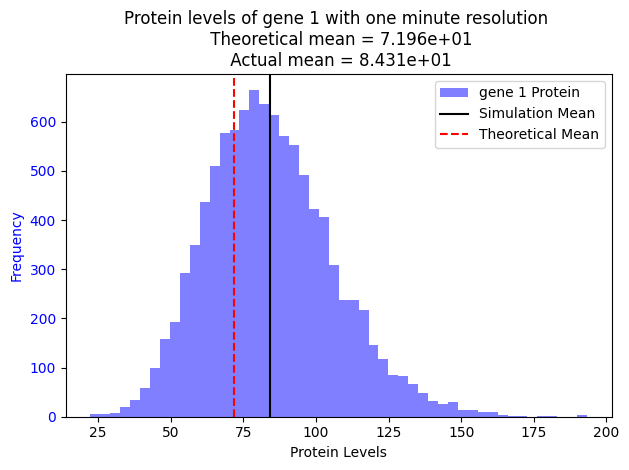

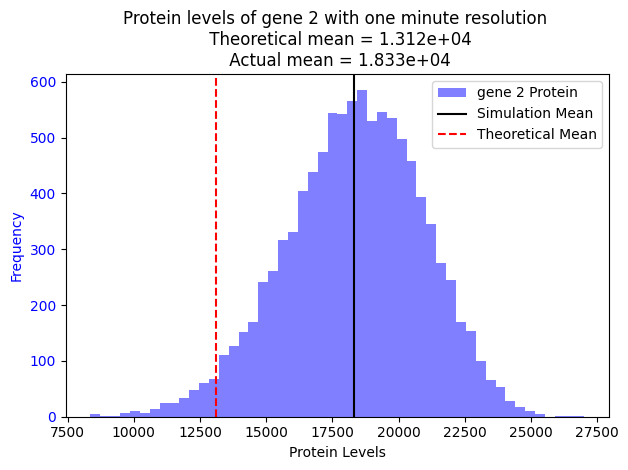

In [5]:
sim_one_min = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulation_data/general_simulation_data/test/simulation_matrix101_A_B_different_params_12_13_thirty_sec_step_no_splicing.csv')
time = 300*2
singleTime_df_one_min = sim_one_min[(sim_one_min['timestep'] == time) & (sim_one_min['replicate'] == 0)]
theoretical_mean_1 = baseline_gene_1
theoretical_mean_2 = 13120
compare_sim_to_theory(singleTime_df_one_min, "gene_1", theoretical_mean_1, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/thirty_sec_vs_theory_gene_1_extreme", title = " with one minute resolution")
compare_sim_to_theory(singleTime_df_one_min, "gene_2", theoretical_mean_2, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/thirty_sec_res_vs_theory_gene_2_extreme", title = " with one minute resolution")

## One-second resolution


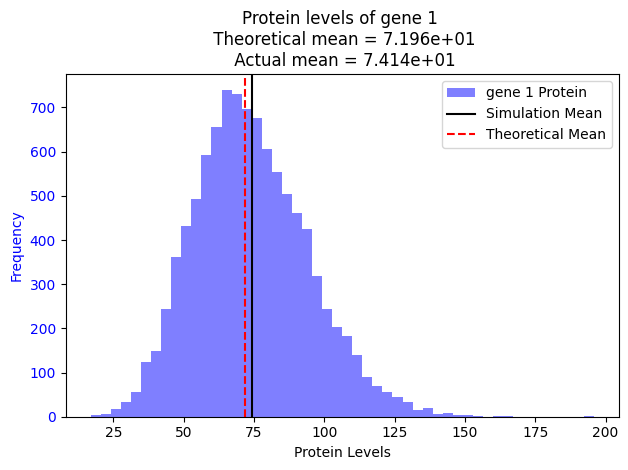

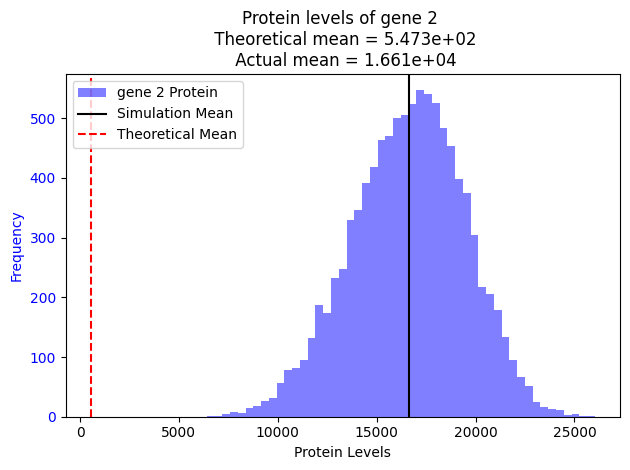

In [6]:
sim_one_sec = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulation_data/general_simulation_data/test/simulation_matrix101_A_B_12_13_fifteen_second_step_no_splicing_500h.csv')
time = 499*60*4
singleTime_df_one_second = sim_one_sec[(sim_one_sec['timestep'] == time) & (sim_one_sec['replicate'] == 0)]
theoretical_mean_1 = baseline_gene_1
theoretical_mean_2 = K_gene_2

compare_sim_to_theory(singleTime_df_one_second, "gene_1", theoretical_mean_1)#, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/one_sec_res_vs_theory_gene_1_14_14_500h", title = " with one second resolution after 100h")
compare_sim_to_theory(singleTime_df_one_second, "gene_2", theoretical_mean_2)#, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/one_sec_res_vs_theory_gene_2_14_14_500h", title = " with one second resolution after 100h")

## Gillespie simulation with 1000 cells


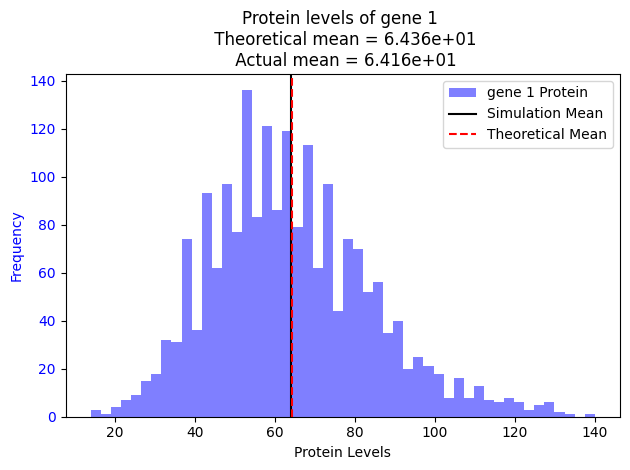

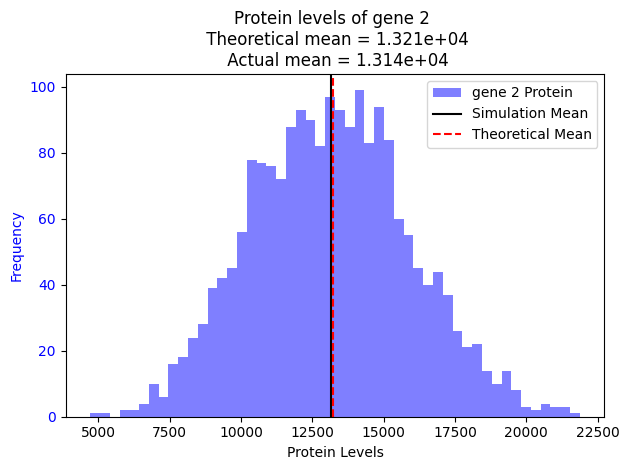

In [13]:
sim_Gillespie_1000_cells = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulation_data/gillespie_simulation_run_2/A_and_B/df_row_0_1_09072025_140849_ncells_10000_A_and_B_ecbef25e.csv')
time = 47
singleTime_df_gillespie = sim_Gillespie_1000_cells[(sim_Gillespie_1000_cells['time_step'] == time)]
theoretical_mean_1 = baseline_gene_1
theoretical_mean_2 = 13210
compare_sim_to_theory(singleTime_df_gillespie, "gene_1", theoretical_mean_1)# , save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_1000_cells_vs_theory_gene_1_extreme_1000h", title = " with Gillespie simulation after 1000h")
compare_sim_to_theory(singleTime_df_gillespie, "gene_2", theoretical_mean_2)#, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_1000_cells_vs_theory_gene_2_extreme_1000h", title = " with Gillespie simulation after 1000h")

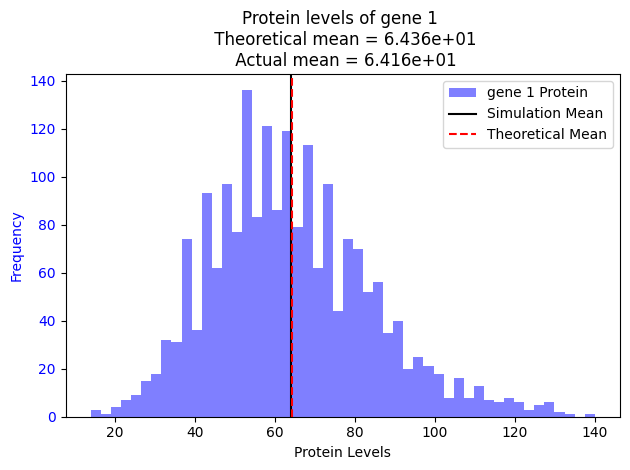

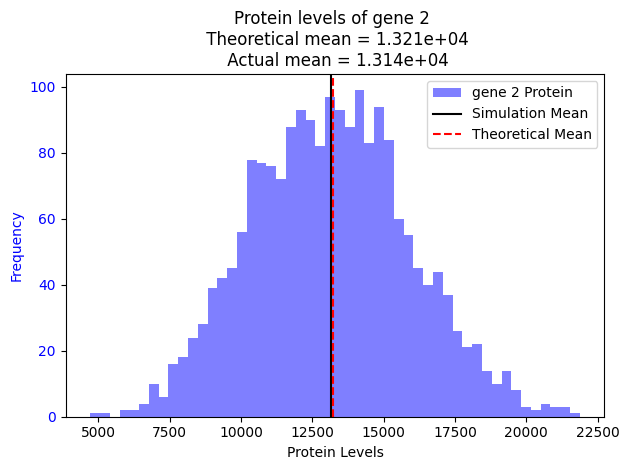

In [17]:
sim_Gillespie_10000_cells = pd.read_csv('/home/mzo5929/Keerthana/grnInference/code/grnInferenceRepo/simulationScripts/gillespie_simulation/df_row_12_13_3406d9ed.csv')
time = 47
singleTime_df_gillespie_10000 = sim_Gillespie_10000_cells[(sim_Gillespie_10000_cells['time_step'] == time)]
theoretical_mean_1 = baseline_gene_1

theoretical_mean_2 = 13210
compare_sim_to_theory(singleTime_df_gillespie_10000, "gene_1", theoretical_mean_1)#, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_10000_cells_vs_theory_gene_1_extreme")
compare_sim_to_theory(singleTime_df_gillespie_10000, "gene_2", theoretical_mean_2)#, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_10000_cells_vs_theory_gene_2_extreme")

In [ ]:
sim_Gillespie_10000_cells = pd.read_csv('/home/mzo5929/Keerthana/grnInference/code/grnInferenceRepo/simulationScripts/gillespie_simulation/test_df_1000_cells_1000h_af596bb8.csv')
time = 999
singleTime_df_gillespie_10000 = sim_Gillespie_10000_cells[(sim_Gillespie_10000_cells['time_step'] == time)]
theoretical_mean_1 = baseline_gene_1
theoretical_mean_2 = K_gene_2
compare_sim_to_theory(singleTime_df_gillespie_10000, "gene_1", theoretical_mean_1)#, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_10000_cells_vs_theory_gene_1_extreme")
compare_sim_to_theory(singleTime_df_gillespie_10000, "gene_2", 13210)#, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_10000_cells_vs_theory_gene_2_extreme")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_std_with_sem(df, gene, theoretical_value, total_cells_expected=10000):
    time_points = df['time_step'].unique()
    mean = []
    std = []
    cell_counts = []

    for time in time_points:
        sub_df = df[df['time_step'] == time]
        values = sub_df[f'{gene}']
        mean.append(values.mean())
        std.append(values.std())
        cell_counts.append(len(values))

    mean = np.array(mean)
    std = np.array(std)
    cell_counts = np.array(cell_counts)
    sem = std / np.sqrt(cell_counts)  # adaptive SEM based on actual N per time point

    plt.figure(figsize=(10, 5))
    plt.plot(time_points, mean, label="mean")
    plt.plot(time_points, std, label="std", color="orange")
    plt.fill_between(time_points, mean - sem, mean + sem, color='blue', alpha=0.2, label="SEM")

    plt.axhline(theoretical_value, linestyle="--", label="Theoretical")
    # plt.axvline(300, linestyle="--", c="red", label="300h")
    # plt.axvline(500, linestyle="--", c="purple", label="500h")
    # plt.axvline(800, linestyle="--", c="grey", label="800h")
    plt.title(f"Mean value of {gene.replace('_', ' ')} with Gillespie simulation ({total_cells_expected} cells)")
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Print diagnostic info
    print(f"\n[{gene}] Diagnostics:")
    print("  Cell count range:", cell_counts.min(), "-", cell_counts.max())
    print("  Mean fluctuation range (last 300h):", np.ptp(mean[-300:]))
    print("  Typical SEM (last 300h):", np.mean(sem[-300:]))
    
# Example usage:
plot_mean_std_with_sem(sim_Gillespie_1000_cells, gene="gene_2_protein", theoretical_value=K_gene_2)
plot_mean_std_with_sem(sim_Gillespie_1000_cells, gene="gene_1_protein", theoretical_value=theoretical_mean_1)

In [ ]:
# Plot mean vs time
gene = "gene_1"
time_points = sim_one_sec['timestep'].unique()
mean = []
std = []
time_steps = []
for time in time_points:
    time_step  = time/3600
    df = sim_one_sec[sim_one_sec['timestep'] == time]
    mean.append(df[f'{gene}_protein'].mean())
    std.append(df[f'{gene}_protein'].std())
    time_steps.append(time_step)

plt.plot(time_steps, mean, label = "mean")
# plt.ylim(0, max(mean)+20)
plt.plot(time_steps, std, label = "std")
plt.axhline(theoretical_mean_1, linestyle = "--", label = "Theoretical")
plt.axvline(300, label = "300h", linestyle = "--", c="red")
plt.axvline(500, label = "500h", linestyle = "--", c="purple")
plt.axvline(800, label = "800h", linestyle = "--", c="grey")
plt.yscale('log')
# plt.axvline(1500, label = "1500h", linestyle = "--", c="green")
plt.title(f"Mean value of {gene.replace('_', ' ')} with one-second resolution simulation (1000 cells)")
plt.legend()
plt.show()

In [ ]:
# Plot mean vs time
time_points = sim_one_sec['timestep'].unique()
mean = []
std = []
time_steps = []
for time in time_points:
    time_step  = time/3600
    df = sim_one_sec[sim_one_sec['timestep'] == time]
    mean.append(df['gene_1_protein'].mean())
    std.append(df['gene_1_protein'].std())
    time_steps.append(time_step)

plt.plot(time_steps, mean, label = "mean")
# plt.ylim(0, max(mean)+20)
plt.plot(time_steps, std, label = "std")
plt.axhline(theoretical_mean_1, linestyle = "--", label = "Theoretical")
plt.axvline(300, label = "300h", linestyle = "--", c="red")
plt.axvline(500, label = "500h", linestyle = "--", c="purple")
plt.axvline(800, label = "800h", linestyle = "--", c="grey")
# plt.axvline(1500, label = "1500h", linestyle = "--", c="green")
plt.legend()
plt.show()

## Overlap the gillespie simulation with one-second resolution


In [20]:
col = 'gene_1_protein'
data1 = singleTime_df_gillespie_10000[col].dropna().values
data2 = singleTime_df_one_second[col].dropna().values
data3 = singleTime_df_one_min[col].dropna().values


In [ ]:
import matplotlib.pyplot as plt

plt.hist(data1, bins=50, density=True, alpha=0.6, label='Gillespie (10k)', linewidth=0.5, edgecolor='black')
plt.hist(data2, bins=50, density=True, alpha=0.6, label='One-second (10k)', linewidth=0.5, edgecolor='black')
plt.hist(data3, bins=50, density=True, alpha=0.6, label='One-minute (10k)', linewidth=0.5, edgecolor='black')

plt.xlabel(col)
plt.ylabel('Density')
plt.title(f'Distribution of {col} at time {time}')
plt.legend()
plt.show()

import seaborn as sns

sns.kdeplot(data1, label='Gillespie (1000)', bw_adjust=1)
sns.kdeplot(data2, label='One-second (10k)', bw_adjust=1)
sns.kdeplot(data3, label='One-minute (10k)', bw_adjust=1)
plt.xlabel(col)
plt.title(f'KDE of {col.replace("_", " ")} at time {time}')
plt.legend()
plt.show()

from scipy.stats import ks_2samp

ks_stat_1_2, ks_p_1_2 = ks_2samp(data1, data2)
print(f"KS statistic for Gillespie vs one second: {ks_stat_1_2:.3f}, p-value: {ks_p_1_2:.3e}")
ks_stat_1_3, ks_p_1_3 = ks_2samp(data1, data3)
print(f"KS statistic for Gillespie vs one minute: {ks_stat_1_3:.3f}, p-value: {ks_p_1_3:.3e}")
ks_stat_2_3, ks_p_2_3 = ks_2samp(data2, data3)
print(f"KS statistic for one second vs one minute: {ks_stat_2_3:.3f}, p-value: {ks_p_2_3:.3e}")

from scipy.spatial.distance import jensenshannon
import numpy as np
# Create histograms with same bins
hist1, bins = np.histogram(data1, bins=100, range=(min(data1.min(), data2.min(), data3.min()), max(data1.max(), data2.max(), data3.max())), density=True)
hist2, _ = np.histogram(data2, bins=bins, density=True)
hist3, _ = np.histogram(data3, bins=bins, density=True)

# Calculate Jensen–Shannon divergence
js_div_1_2 = jensenshannon(hist1, hist2)
js_div_1_3 = jensenshannon(hist1, hist3)
js_div_2_3 = jensenshannon(hist2, hist3)

print(f"Jensen–Shannon divergence for Gillespie vs one second: {js_div_1_2:.4f}")
print(f"Jensen–Shannon divergence for Gillespie vs one minute: {js_div_1_3:.4f}")
print(f"Jensen–Shannon divergence for one second vs one minute: {js_div_2_3:.4f}")
